# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [23]:
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scipy as sp
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from scipy import stats
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## 1. Data Cleaning

In [24]:
df = pd.read_csv('student_data.csv')
hold_out_df = pd.read_csv('hold_out_features.csv')

In [25]:
df.shape

(23999, 25)

In [26]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [27]:
df['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [28]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,-2,-2,316,316,316,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


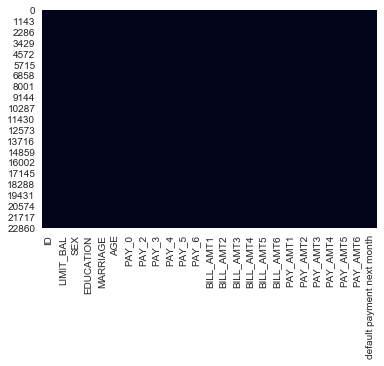

In [29]:
sns.heatmap(df.isnull(), cbar = False)

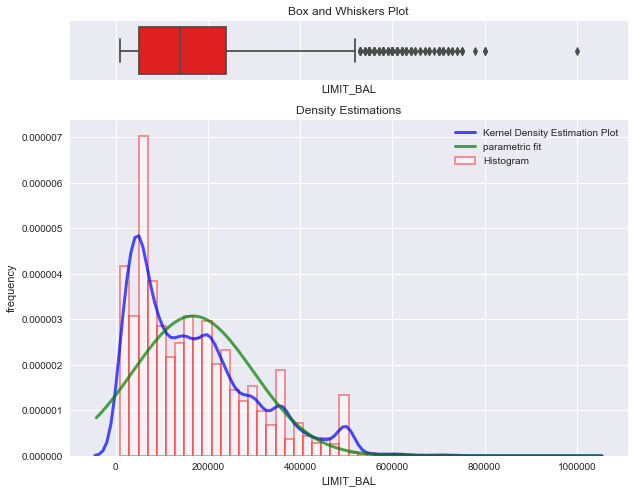

In [30]:
fig, (ax, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (10,8) )

sns.distplot(df['LIMIT_BAL'], 
             hist=True, hist_kws={
                                  "linewidth": 2,
                                  "edgecolor" :'red',
                                  "alpha": 0.4, 
                                  "color":  "w",
                                  "label": "Histogram",
                                  },
             kde=True, kde_kws = {'linewidth': 3,
                                  'color': "blue",
                                  "alpha": 0.7,
                                  'label':'Kernel Density Estimation Plot'
                                 },
             fit= sp.stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
             ax=ax2)
ax2.set_ylabel('frequency')
ax2.set_title('Density Estimations')
sns.boxplot(x=df['LIMIT_BAL'], ax = ax,color = 'red')
ax.set_title('Box and Whiskers Plot')
plt.legend();

In [31]:
limit_log = np.log(df.LIMIT_BAL)

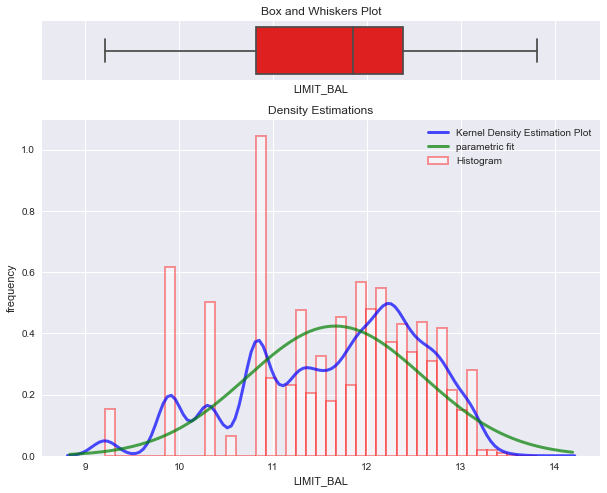

In [32]:
fig, (ax, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (10,8) )

sns.distplot(limit_log, 
             hist=True, hist_kws={
                                  "linewidth": 2,
                                  "edgecolor" :'red',
                                  "alpha": 0.4, 
                                  "color":  "w",
                                  "label": "Histogram",
                                  },
             kde=True, kde_kws = {'linewidth': 3,
                                  'color': "blue",
                                  "alpha": 0.7,
                                  'label':'Kernel Density Estimation Plot'
                                 },
             fit= sp.stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
             ax=ax2)
ax2.set_ylabel('frequency')
ax2.set_title('Density Estimations')
sns.boxplot(x=limit_log, ax = ax,color = 'red')
ax.set_title('Box and Whiskers Plot')
plt.legend();

In [33]:
pay_dict = {-2:-1}
df.PAY_0.replace(pay_dict, inplace = True)
df.PAY_2.replace(pay_dict, inplace = True)
df.PAY_3.replace(pay_dict, inplace = True)
df.PAY_4.replace(pay_dict, inplace = True)
df.PAY_5.replace(pay_dict, inplace = True)
df.PAY_6.replace(pay_dict, inplace = True)

In [34]:
df['statement_delta'] = df['BILL_AMT1'] - df['BILL_AMT6']
df.statement_delta.describe()

count     23999.000000
mean      12362.182299
std       44141.497170
min     -428791.000000
25%       -2946.000000
50%         938.000000
75%       19828.000000
max      708323.000000
Name: statement_delta, dtype: float64

In [35]:
df['credit_utilization'] = ((df['BILL_AMT1']+df['BILL_AMT2']+df['BILL_AMT3']+df['BILL_AMT4']+df['BILL_AMT5']+df['BILL_AMT6'])/6)/df['LIMIT_BAL']

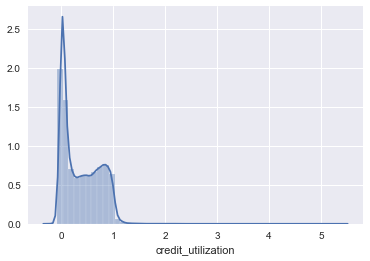

In [36]:
sns.distplot(df['credit_utilization'])

In [45]:
df['credit_utilization']

0        0.001046
1        0.542003
2        0.078257
3        0.639975
4        0.983186
           ...   
23994    0.087653
23995    0.064921
23996    0.905577
23997    0.731603
23998    0.270537
Name: credit_utilization, Length: 23999, dtype: float64

In [41]:
for i in range(len((df[df['credit_utilization'] > 1].ID.values))):
    for j in range(len((df['ID']))):
        if df['ID'][j] == df[df['credit_utilization'] > 1].ID.values[i]:
            df.loc['credit_utilization'][j] = 1

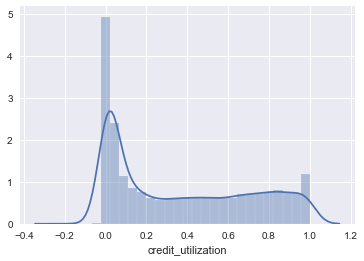

In [46]:
sns.distplot(df['credit_utilization'])

## 2. EDA

In [24]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,statement_delta,credit_utilization
0,2873,350000,1,1,2,37,-1,-1,-1,-1,-1,-1,316,316,316,466,466,316,316,316,466,466,316,316,0,0,0.001046
1,3598,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0,27497,0.542003
2,27623,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0,2770,0.078257
3,6874,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0,-2839,0.639975
4,6444,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0,2077,0.983186


## 3. Feature Engineering

In [47]:
diff = 0
payment_diffs = []
status_sum = 0
status_sum_list = []
last_3_avg = 0
first_3_avg = 0 
avg_outstanding_declining = []
for i in range(len(df)):
    diff += (df['BILL_AMT1'][i] - df['PAY_AMT1'][i])
    diff += (df['BILL_AMT2'][i] - df['PAY_AMT2'][i])
    diff += (df['BILL_AMT3'][i] - df['PAY_AMT3'][i])
    diff += (df['BILL_AMT4'][i] - df['PAY_AMT4'][i])
    diff += (df['BILL_AMT5'][i] - df['PAY_AMT5'][i])
    diff += (df['BILL_AMT6'][i] - df['PAY_AMT6'][i])
    payment_diffs.append(diff)
    
    status_sum += df['PAY_0'][i]
    status_sum += df['PAY_2'][i]
    status_sum += df['PAY_3'][i]
    status_sum += df['PAY_4'][i]
    status_sum += df['PAY_5'][i]
    status_sum += df['PAY_6'][i]
    status_sum_list.append(status_sum)
    
    last_3_avg += (df['BILL_AMT1'][i] - df['PAY_AMT1'][i])
    last_3_avg += (df['BILL_AMT2'][i] - df['PAY_AMT2'][i])
    last_3_avg += (df['BILL_AMT3'][i] - df['PAY_AMT3'][i])
    last_3_avg = last_3_avg/3
    
    first_3_avg += (df['BILL_AMT4'][i] - df['PAY_AMT4'][i])
    first_3_avg += (df['BILL_AMT5'][i] - df['PAY_AMT5'][i])
    first_3_avg += (df['BILL_AMT6'][i] - df['PAY_AMT6'][i])
    first_3_avg = first_3_avg/3
    
    if last_3_avg < first_3_avg:
        avg_outstanding_declining.append(1)
    else:
        avg_outstanding_declining.append(0)
    
    last_3_avg = 0
    first_3_avg = 0
    diff = 0
    status_sum = 0
    
df['payment_diffs'] = payment_diffs
df['status_sum'] = status_sum_list
df['avg_outstanding_declining'] = avg_outstanding_declining

In [48]:
bills = abs(df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'] + 1)
payments = abs(df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'])
df["percent_bill_paid"] = payments / bills
df['percent_bill_paid'] = df['percent_bill_paid'].apply(lambda x : 1 if x > 1 else x)  

In [49]:
#marriage 1,2,3,0 -> [0,3],1,2
#education 1,2,3,4,5,6 - > [4,5,6,0], 1,2,3
marriage_map = {3 : 0}
education_map = {4: 0, 5: 0, 6: 0}
df['MARRIAGE'].replace(marriage_map, inplace=True)
df['EDUCATION'].replace(education_map, inplace=True)
#student_data.EDUCATION.value_counts(), student_data.MARRIAGE.value_counts()
a =pd.get_dummies(df['MARRIAGE'], drop_first = True, prefix = 'MARRIAGE')
b = pd.get_dummies(df['EDUCATION'], drop_first = True, prefix = 'EDUCATION')
df = pd.concat([df, a, b], axis = 1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,statement_delta,credit_utilization,payment_diffs,status_sum,avg_outstanding_declining,percent_bill_paid,MARRIAGE_1,MARRIAGE_2,EDUCATION_1,EDUCATION_2,EDUCATION_3
0,2873,350000,1,1,2,37,-1,-1,-1,-1,-1,-1,316,316,316,466,466,316,316,316,466,466,316,316,0,0,0.001046,0,-6,1,0.999545,0,1,1,0,0
1,3598,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0,27497,0.542003,154721,6,0,0.048462,1,0,0,1,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0,2770,0.078257,358,-6,1,0.984709,0,1,1,0,0
3,6874,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0,-2839,0.639975,71809,2,1,0.064950,1,0,0,0,1
4,6444,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0,2077,0.983186,621603,0,1,0.042071,0,1,0,1,0


## 4. Feature Selection

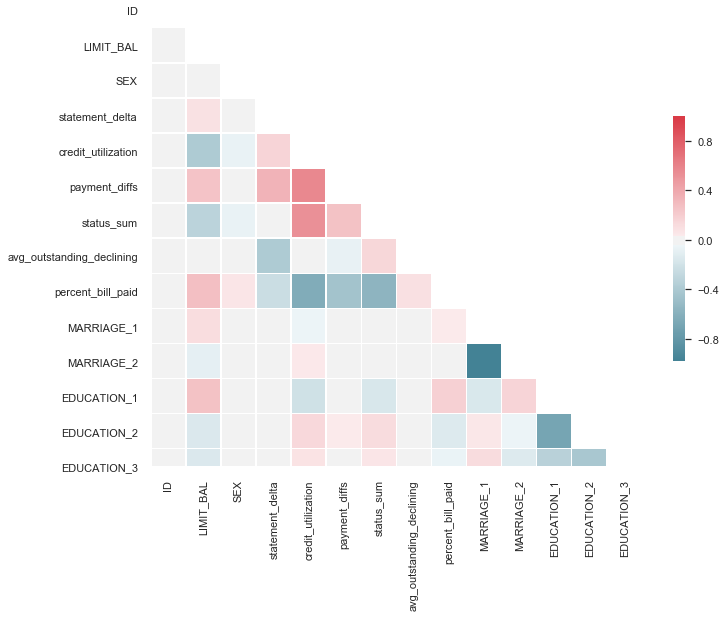

In [53]:
sns.set(style="white")

corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df['default']

In [38]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'statement_delta', 'credit_utilization',
       'payment_diffs', 'status_sum', 'avg_outstanding_declining',
       'percent_bill_paid', 'MARRIAGE_1', 'MARRIAGE_2', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3'],
      dtype='object')

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [56]:
X = df.drop(columns = ['default payment next month', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])
y = df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#poly_2 = PolynomialFeatures(degree=2, interaction_only=False)
#X_train_poly = pd.DataFrame(poly_2.fit_transform(X_train), columns=poly_2.get_feature_names(X_train.columns))
#X_test_poly = pd.DataFrame(poly_2.transform(X_test), columns=poly_2.get_feature_names(X_test.columns))

In [59]:
training  = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
not_defaulted = training[training['default payment next month'] == 0]
defaulted = training[training['default payment next month'] == 1]
# upsample minority
defaulted_upsampled = resample(defaulted,
                          replace=True, # sample with replacement
                          n_samples=len(not_defaulted), # match number in majority class
                          random_state=23) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([not_defaulted, defaulted_upsampled])
# check new class counts
upsampled['default payment next month'].value_counts()

X_upsample = upsampled.drop(columns = ['default payment next month'])
y_upsample = upsampled['default payment next month']

In [64]:
#rf_model = RandomForestClassifier(n_estimators = 1500, max_depth = 10, criterion = 'gini')
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_model.fit(X_train, y_train)
y_preds = rf_model.predict(X_test)
f1 = metrics.f1_score(y_test,y_preds)
print("f1 score: {}".format(f1))

f1 score: 0.4134432466708941


In [130]:
#get all my preds from different sources
a = pd.Series(y_preds_rf_model_unsampled)# = y_preds
b = pd.Series(y_preds_rf_model_upsampled)# = y_preds
c = pd.Series(y_preds_xg_clf_upsampled)# = preds
d = pd.Series(y_preds_xg_clf_unsampled)# = preds
e = pd.Series(y_preds_knn_unsampled)# = y_pred_test
f = pd.Series(y_preds_knn_upsampled)# = y_pred_test

df_pred = pd.concat([a,b,c,d,e,f], axis=1)


In [91]:
df_pred.columns = ['a','b','c','d','e','f','target']

In [84]:
df['default payment next month'].shape, X

(23999,)

In [96]:
print(y_preds_rf_model_unsampled)
print(y_preds_rf_model_upsampled)
print(y_preds_xg_clf_unsampled)
print(y_preds_xg_clf_upsampled)
print(y_preds_knn_unsampled)
print(y_preds_knn_upsampled)


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 1 0 0]


In [104]:
f1_score(y_test, final_preds_from_moels)

0.35418038183015144

In [ ]:
f1_score()

In [103]:
df_pred.shape, y_test.shape, final_preds_from_moels.shape

((4800, 6), (4800,), (4800,))

In [131]:

X_preds_train, X_preds_test, y_preds_train, y_preds_test = train_test_split(df_pred, y_test, test_size = 0.2)

In [132]:
rf_pred_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_pred_model.fit(X_preds_train, y_preds_train)
y_preds_preds = rf_pred_model.predict(X_preds_test)
test_f1_rf = f1_score(y_preds_test, preds_final_final)
test_acc_rf = accuracy_score(y_preds_test, preds_final_final)
print("Accuracy: %f" % (test_acc_rf))
print("F1: %f" % (test_f1_rf))

Accuracy: 0.710417
F1: 0.147239


In [133]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 3, 
                           alpha = 1, 
                           n_estimators = 1000)
xg_clf.fit(X_preds_train,y_preds_train)
preds_final_final = xg_clf.predict(X_preds_test)
test_f1 = f1_score(y_preds_test, preds_final_final)
test_acc = accuracy_score(y_preds_test, preds_final_final)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.803125
F1: 0.396166


In [ ]:
xg_clf.predict()

In [81]:
df_pred.head(1000)

,0,1,2,3,4,5
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,1
6,0,0,0,0,0,1
7,0,0,0,0,0,0
8,0,0,0,0,0,1
9,0,1,0,0,1,1


In [69]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 5, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.767708
F1: 0.365396


In [42]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.7814583333333334
Test F1 score:  0.0


/Users/lucas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
knclassifier = KNeighborsClassifier(n_neighbors = 4)
knclassifier.fit(X_upsample, y_upsample)
y_pred_test = knclassifier.predict(X_test)
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.6527083333333333
Test F1 score:  0.3444750294927251


1    14946
0    14946
Name: default payment next month, dtype: int64

In [56]:
X_train = upsampled.drop(columns = ['default payment next month'])
y_train = upsampled['default payment next month']

In [57]:
rf_model = RandomForestClassifier(n_estimators = 1500, max_depth = 10, criterion = 'gini', min_samples_split = 5)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print('Test Accuracy score: ', accuracy_score(y_test, y_pred))
print('Test F1 score: ', f1_score(y_test, y_pred))

Test Accuracy score:  0.7591666666666667
Test F1 score:  0.5080851063829788


In [48]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 5, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.770625
F1: 0.388673


In [49]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.6795833333333333
Test F1 score:  0.444364161849711


In [50]:
knclassifier = KNeighborsClassifier(n_neighbors = 4)
knclassifier.fit(X_train, y_train)
y_pred_test = knclassifier.predict(X_test)
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.6510416666666666
Test F1 score:  0.34184675834970535


In [52]:
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[1000,1500,2000], 'max_depth':[3,4,5,6,7,8,9,10], 'max_features':[None, 'log2', 'sqrt']}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(X_train, y_train)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.662391,0.012362,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
1,0.662391,0.012362,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
2,0.662392,0.012309,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
3,0.659903,0.010704,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
4,0.661428,0.010211,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
5,0.660525,0.010295,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
6,0.660571,0.009538,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
7,0.660705,0.009899,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
8,0.661301,0.009657,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
9,0.679535,0.008879,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."


In [53]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.7834002937191178
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'n_estimators': 1500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [58]:
param_grid = {'criterion':['gini'], 'n_estimators':[2000], 'max_depth':[10], 'max_features':[None], 'min_samples_split':[5]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(X_train, y_train)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.782927,0.009308,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."


In [59]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.7829269862658331
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 2000}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
param_grid = {'objective':['binary:logistic'], 
            'colsample_bytree':[0.4, 0.5, 0.6],
            'subsample':[0.4, 0.5, 0.6],
            'learning_rate':[0.2,0.3,0.4],
            'max_depth':[3,4,5,6],
            'alpha':[0.4,0.5,0.6], 
            'scale_pos_weight':[0.4,0.5,0.6],
            'n_estimators':[10000]}
xgb_grid = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
xgb_grid.fit(X_train, y_train)
pd.DataFrame(xgb_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

## 6. Model Evaluation

In [99]:
#Given: list of prediction Series
#Return: Series of determined predictions based on votes
def aggregate(y_preds):
    prediction_list = []
    for y in y_preds:
        prediction_list.append(np.array(y).tolist())
    length = len(prediction_list[0])
    n = len(prediction_list) # number of prediction vectors
    final_preds = []
    for y in range(0, length): # for each row
        ttl_score = 0
        for i in prediction_list: #for each column
            ttl_score += i[y]
        if (ttl_score > (n // 2)):
            final_preds.append(1)
        else:
            final_preds.append(0)
    return pd.Series(final_preds)

In [100]:
final_preds_from_moels = aggregate([a,b,c,d,e,f])

In [102]:
final_preds_from_moels.shape

(4800,)

## 7. Final Model